In [1]:
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import EntropyHub as EH
import numpy as np
import math
from scipy.integrate import quad


# 文件路径
file_path = "data/对照组/H06蒙树侠等6个文件/H01陈秋连/upper/chenqiulian_upper_RBB_preprocess.txt"  # 请替换为你的文件路径

# 打开文件
with open("../" + file_path, "r") as file:
    # 跳过前10行
    for _ in range(10):
        next(file)
    
    # 读取剩余的内容
    remaining_content = file.read()

    # 使用 StringIO 将字符串内容转为文件对象
    file_like_object = StringIO(remaining_content)

    # 读取数据到 Pandas DataFrame
    df = pd.read_csv(file_like_object, delimiter=r"\s+")

# 打印剩余的内容
df.set_index('Frame', inplace=True)


column = df.columns[1]
x_column = df.columns[0]


# 找到NaN值所在的行索引
nan_indices = df.index[df[column].isna()].tolist()

# 检查是否有足够的NaN值来拆分成五段
if len(nan_indices) < 6:
    print("NaN值的数量不足以拆分成五段。")
else:
    # 创建一个用于存储拆分后的DataFrame的列表
    split_dfs = []

    # 初始化拆分段的起始索引
    start_index = 0

    # 拆分文件成五段
    for i in range(5):
        # 寻找下一个连续的NaN值段
        while start_index < len(nan_indices) - 1 and nan_indices[start_index + 1] - nan_indices[start_index] == 1:
            start_index += 1

        # 计算当前段的起始和结束索引
        act_start = nan_indices[start_index] + 1
        if start_index < len(nan_indices) - 1:
            act_end = nan_indices[start_index + 1] - 1
        else:
            act_end = len(df) - 1

        print(f"第 {i + 1} 段起始索引：{act_start}，结束索引：{act_end}")

        # 切片并将段添加到拆分后的DataFrame列表中
        split_df = df.iloc[act_start:act_end + 1]
        split_dfs.append(split_df)

        # 移动起始索引到下一个不连续的NaN值段
        start_index += 1

# 打印每个拆分段的数据框（示例）
for i, split_df in enumerate(split_dfs):
    print(f"拆分段 {i + 1}:\n{split_df}")


# 创建一个用于存储拆分后的DataFrame的列表
split_iEMG = []
sample_rate = 1000  # 采样率（Hz）
split_MPF = []
split_MF = []

from scipy.signal import welch


for i, split_df in enumerate(split_dfs):
    abs_emg = split_df[column]

    # 计算iEMG
    split_iEMG.append(np.trapz(y = np.abs(abs_emg), x = split_df[x_column], dx=0.001))

    # 这里使用welch方法来估计功率谱密度
    freq, power_density = welch(abs_emg, fs=sample_rate, nperseg=1024)

    # 计算MPF#@
    weighted_freq = np.sum(freq * power_density) / np.sum(power_density)
    split_MPF.append(weighted_freq)

    # 计算MF
    MF = freq[np.argmax(np.cumsum(power_density) >= 0.5)]
    split_MF.append(MF)


# 打印 iEMG
for i, iEMG_df in enumerate(split_iEMG):
    print(f"拆分段 {i + 1} iEMG:\n{iEMG_df}")

# 打印MPF
for i, iEMG_df in enumerate(split_MPF):
    print(f"拆分段 {i + 1} iEMG:\n{iEMG_df}")

# 打印MF
for i, iEMG_df in enumerate(split_MF):
    print(f"拆分段 {i + 1} iEMG:\n{iEMG_df}")




第 1 段起始索引：28855，结束索引：74972
第 2 段起始索引：118807，结束索引：164997
第 3 段起始索引：209568，结束索引：254431
第 4 段起始索引：298033，结束索引：344203
第 5 段起始索引：389963，结束索引：434570
拆分段 1:
         Time      RBB
Frame                 
28855  28.855   33.695
28856  28.856   20.753
28857  28.857    3.601
28858  28.858  -15.861
28859  28.859  -36.652
...       ...      ...
74968  74.968  521.333
74969  74.969  569.451
74970  74.970  521.756
74971  74.971  376.699
74972  74.972  196.259

[46118 rows x 2 columns]
拆分段 2:
           Time      RBB
Frame                   
118807  118.807  -36.185
118808  118.808  -40.258
118809  118.809  -39.996
118810  118.810  -34.198
118811  118.811  -23.108
...         ...      ...
164993  164.993 -283.308
164994  164.994 -347.411
164995  164.995 -317.399
164996  164.996 -139.409
164997  164.997  136.605

[46191 rows x 2 columns]
拆分段 3:
           Time     RBB
Frame                  
209568  209.568 -33.958
209569  209.569 -14.289
209570  209.570   0.061
209571  209.571   0.795
209572  209.572 

In [46]:
# iEMG
print(split_iEMG)

[1133.9432360000042, 1383.8164740000136, 1287.4168154999848, 1221.498683999949, 1227.5238720000577]


In [3]:
# MPF
print(split_MPF)

[56.495273558939786, 58.14704099985398, 57.79679461133906, 57.904280680392745, 57.14948938700719]


In [2]:
# MF
print(split_MF)

[0.0, 14.6484375, 0.9765625, 0.9765625, 0.9765625]


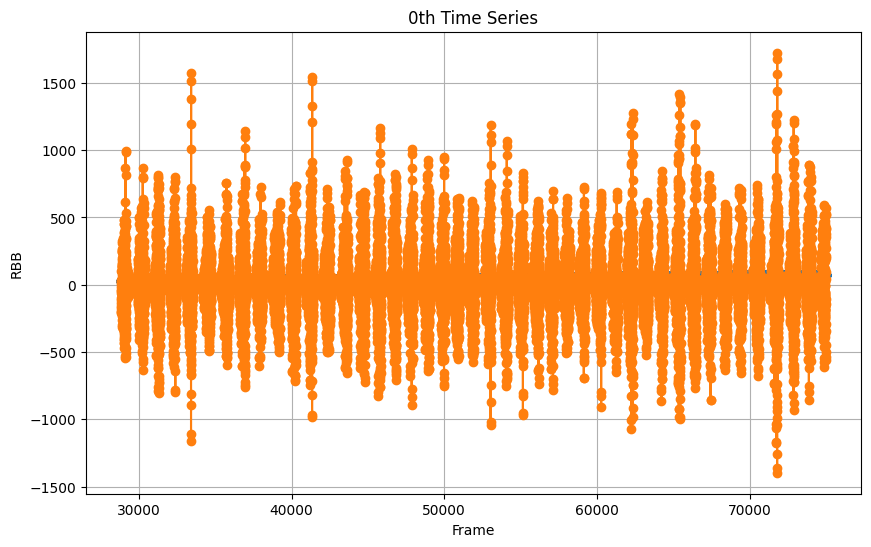

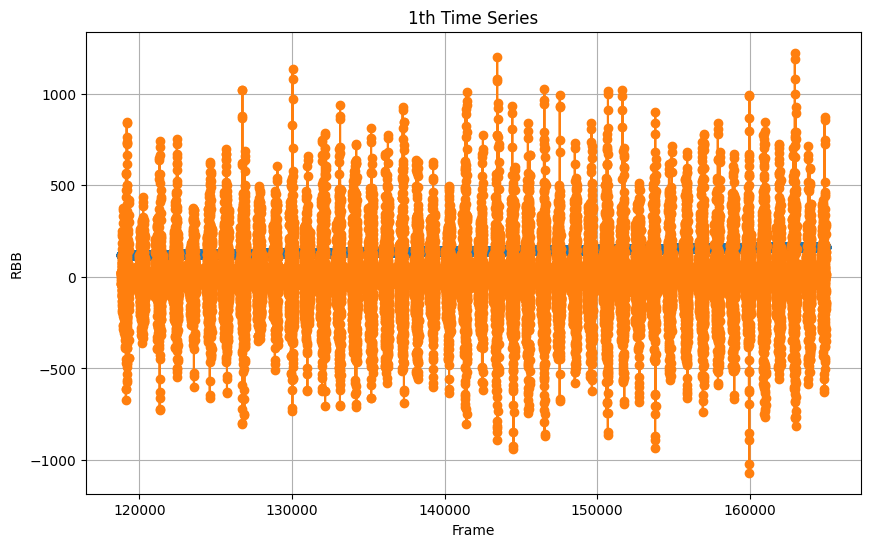

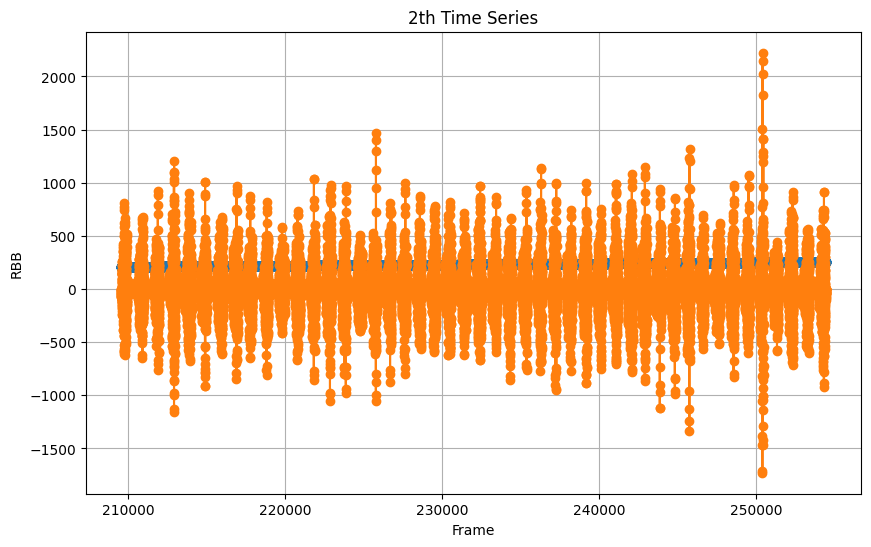

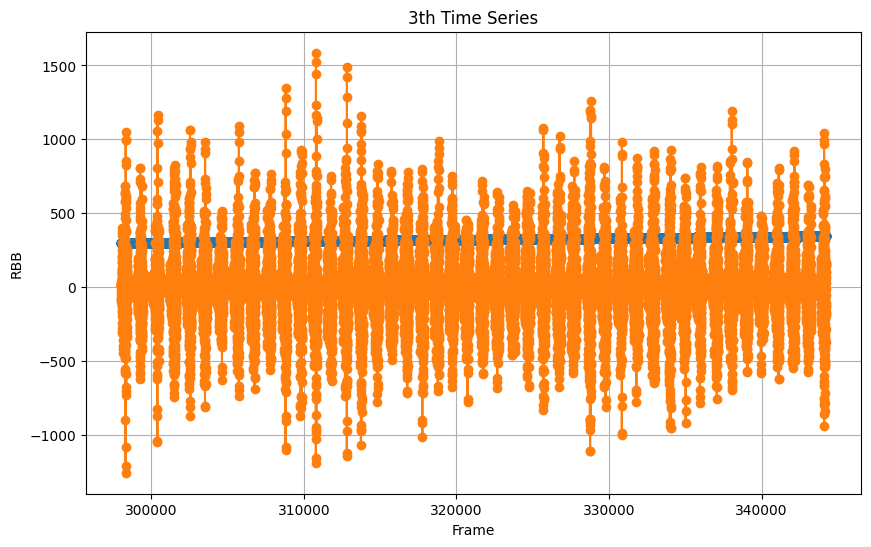

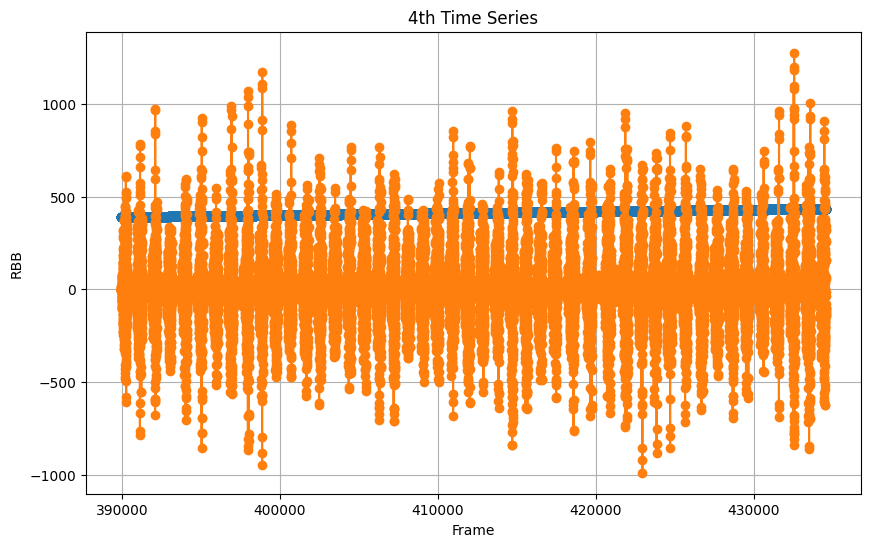

In [4]:
for i, split_df in enumerate(split_dfs):

    # 创建时间序列图
    plt.figure(figsize=(10, 6))  # 可以调整图形大小
    plt.plot(split_df, marker='o', linestyle='-')  # 使用圆点连接线
    plt.xlabel("Frame")
    plt.ylabel(column)
    plt.title(f"{i}th Time Series")
    plt.grid(True)  # 添加网格线
    plt.show()
